# Aprendizado de Máquina
- Alef Segura Santos, 9762942
- Gustavo de Moura Souza, 9762981

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from skimage.io import imread, imsave, imshow
from skimage.util import random_noise, invert
from skimage.transform import rotate
from skimage.filters import gaussian
from skimage.feature import hog

____
## Parte 1 - Pré-processamento

### Data Augmentation

In [2]:
images = []
labels = []

for i in range(20):
    folder = 'datasets/PessoasICMC/p' + str(i+1) + '/'
    image_name = str(i+1)
    
    image = imread(folder + image_name + '.png')
    image_45r = rotate(image, preserve_range=True, mode='constant', cval=1, angle=30)
    image_45l = rotate(image, preserve_range=True, mode='constant', cval=1, angle=330)
    image_blur = gaussian(image)
    image_invert = invert(image)
    image_noisy = random_noise(image, mode='pepper')
    image_45r_noisy = rotate(image_noisy, preserve_range=True, mode='constant', cval=1, angle=30)
    image_45l_noisy = rotate(image_noisy, preserve_range=True, mode='constant', cval=1, angle=330)
    image_blur_noisy = random_noise(image_blur, mode='pepper')
    image_invert_noisy = random_noise(image_invert, mode='pepper')

    labels += [image_name for i in range(10)]
    images += [image, image_45r, image_45l, image_blur, image_invert,
               image_noisy, image_45r_noisy, image_45l_noisy, image_blur_noisy, image_invert_noisy]

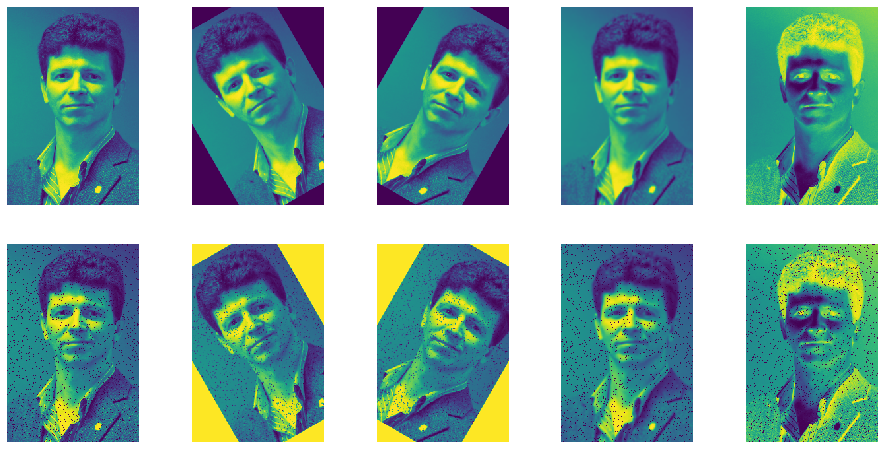

In [3]:
plt.figure(figsize=(16, 8))
for i in range(10):
    plt.subplot(2, 5, i+1)
    plt.grid(False)
    plt.imshow(images[i+50])
    plt.gca().set_frame_on(False)
    plt.gca().get_yaxis().set_visible(False)
    plt.gca().get_xaxis().set_visible(False)
plt.show()

### Histogram of Oriented Gradients

In [4]:
images_hog = []
for img in images:
    images_hog.append(hog(img, visualize=True))

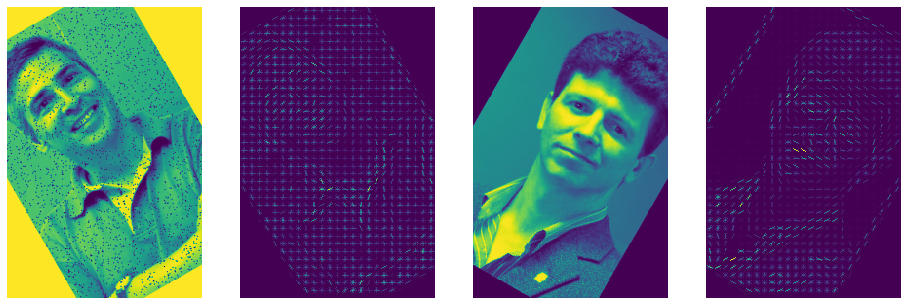

In [5]:
fig = plt.figure(figsize=(16,6))

fig.add_subplot(141)
plt.grid(False)
plt.imshow(images[16])
plt.gca().set_frame_on(False)
plt.gca().get_yaxis().set_visible(False)
plt.gca().get_xaxis().set_visible(False)
    
fig.add_subplot(142)
plt.grid(False)
plt.imshow(images_hog[16][1])
plt.gca().set_frame_on(False)
plt.gca().get_yaxis().set_visible(False)
plt.gca().get_xaxis().set_visible(False)

fig.add_subplot(143)
plt.grid(False)
plt.imshow(images[52])
plt.gca().set_frame_on(False)
plt.gca().get_yaxis().set_visible(False)
plt.gca().get_xaxis().set_visible(False)

fig.add_subplot(144)
plt.grid(False)
plt.imshow(images_hog[52][1])
plt.gca().set_frame_on(False)
plt.gca().get_yaxis().set_visible(False)
plt.gca().get_xaxis().set_visible(False)

plt.show()

___
## Parte 2 - Classificadores

In [47]:
from sklearn.neighbors import KNeighborsClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.model_selection import StratifiedKFold, cross_validate, train_test_split
from sklearn.decomposition import PCA
from sklearn.metrics import confusion_matrix, accuracy_score

# KFold
kf = StratifiedKFold(10)

# X/y
X = [img[1].reshape(60000) for img in images_hog]
y = labels

### Testes

In [84]:
# KNN
scores_knn = []
K = [3, 5, 7]
for k in K:
    knn = KNeighborsClassifier(k)
    cv = cross_validate(knn, X, y, cv=kf, return_train_score=True)
    scores_knn.append({'K' : k,
                      'Test Scores' : cv['test_score'],
                      'Test Mean' : np.mean(cv['test_score']),
                      'Train Scores' :cv['train_score'],
                      'Train Mean' : np.mean(cv['train_score'])})

In [86]:
df_knn = pd.DataFrame(scores_knn).set_index('K')
df_knn

,Test Mean,Test Scores,Train Mean,Train Scores
K,,,,
3,0.333333,"[0.3, 0.4, 0.3]",0.437302,"[0.5333333333333333, 0.32857142857142857, 0.45]"
5,0.348611,"[0.2625, 0.4666666666666667, 0.31666666666666665]",0.339683,"[0.43333333333333335, 0.32857142857142857, 0.2..."
7,0.405556,"[0.3, 0.5166666666666667, 0.4]",0.330556,"[0.39166666666666666, 0.32857142857142857, 0.2..."


In [10]:
# MLP
scores_mlp = []
layers = [(5,10), (8,13), (5,), (10,)]
alphas = [0.4, 0.7]
momentums = [0.6, 0.8]
for layer in layers:
    for alpha in alphas:
        for momentum in momentums:
            mlp = MLPClassifier(hidden_layer_sizes=layer, alpha=alpha, momentum=momentum, max_iter=500)
            cv = cross_validate(mlp, X, y, cv=kf, return_train_score=True)
            scores_mlp.append({'Layers' : layer,
                               'Alpha' : alpha,
                               'Momentum' : momentum,
                               'Test Score' : cv['test_score'],
                               'Test Mean' : np.mean(cv['test_score']),
                               'Train Score' : cv['train_score'],
                               'Train Mean' : np.mean(cv['train_score'])})

KeyboardInterrupt: 

In [11]:
df_mlp = pd.DataFrame(scores_mlp).set_index(['Layers','Alpha','Momentum'])
df_mlp

Test Mean                        Test Score  \
Layers  Alpha Momentum                                                
(5, 10) 0.4   0.6        0.050000                [0.05, 0.05, 0.05]   
              0.8        0.050000                [0.05, 0.05, 0.05]   
        0.7   0.6        0.050000                [0.05, 0.05, 0.05]   
              0.8        0.050000                [0.05, 0.05, 0.05]   
(8, 13) 0.4   0.6        0.072222  [0.1, 0.06666666666666667, 0.05]   
              0.8        0.050000                [0.05, 0.05, 0.05]   
        0.7   0.6        0.054167              [0.0625, 0.05, 0.05]   
              0.8        0.050000                [0.05, 0.05, 0.05]   
(5,)    0.4   0.6        0.050000                [0.05, 0.05, 0.05]   
              0.8        0.050000                [0.05, 0.05, 0.05]   
        0.7   0.6        0.050000                [0.05, 0.05, 0.05]   
              0.8        0.050000                [0.05, 0.05, 0.05]   

                        Train Mean  \
Layers  Alpha Momentum               
(5, 10) 0.4   0.6         0.050000   
              0.8         0.050000   
        0.7   0.6         0.050000   
              0.8         0.050000   
(8, 13) 0.4   0.6         0.068254   
              0.8         0.050000   
        0.7   0.6         0.052778   
              0.8         0.050000   
(5,)    0.4   0.6         0.050000   
              0.8         0.050000   
        0.7   0.6         0.050000   
              0.8         0.050000   

                                                             Train Score  
Layers  Alpha Momentum                                                    
(5, 10) 0.4   0.6                                     [0.05, 0.05, 0.05]  
              0.8                                     [0.05, 0.05, 0.05]  
        0.7   0.6                                     [0.05, 0.05, 0.05]  
              0.8                                     [0.05, 0.05, 0.05]  
(8, 13) 0.4   0.6       [0.08333333333333333, 0.07142857142857142, 0.05]  
              0.8                                     [0.05, 0.05, 0.05]  
        0.7   0.6                     [0.058333333333333334, 0.05, 0.05]  
              0.8                                     [0.05, 0.05, 0.05]  
(5,)    0.4   0.6                                     [0.05, 0.05, 0.05]  
              0.8                                     [0.05, 0.05, 0.05]  
        0.7   0.6                                     [0.05, 0.05, 0.05]  
              0.8                                     [0.05, 0.05, 0.05]

### Modelos Escolhidos

In [82]:
X_train, X_test, y_train, y_test = train_test_split(X,y,random_state=0,shuffle=True)

In [83]:
# KNN
knn = KNeighborsClassifier(7).fit(X_test, y_test)
y_pred = knn.predict(X_test)
confusion_matrix(y_test, y_pred)

array([[4, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
       [1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
       [1, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
       [0, 0, 0, 2, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
       [1, 0, 0, 0, 2, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
       [1, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
       [0, 0, 0, 1, 0, 0, 0, 3, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
       [1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
       [1, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
       [1, 0, 0, 1, 0, 0, 1, 0, 0, 0, 2, 0, 0, 0, 0, 0, 0, 0, 0],
       [3, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
       [2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
       [1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
       [1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0],
       [1,

In [84]:
# MLP
mlp = MLPClassifier(hidden_layer_sizes=(8,3), alpha=0.4, momentum=0.6, max_iter=500).fit(X_test, y_test)
y_pred = mlp.predict(X_test)
confusion_matrix(y_test, y_pred)

array([[0, 0, 0, 0, 0, 0, 4, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0, 3, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0, 4, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0, 3, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0, 4, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0, 3, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0, 5, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0, 3, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
       [0,

### PCA

In [51]:
# PCA
pca = PCA(n_components=50)
X_pca = pca.fit_transform(X)

In [87]:
i = 0
summ = pca.explained_variance_ratio_[i]
while(summ < 0.5):
    i +=1
    summ += pca.explained_variance_ratio_[i]    

print(i, 'componentes, variância: %.2f' % summ, '%')

6 componentes, variância: 0.51 %


In [78]:
X_train, X_test, y_train, y_test = train_test_split(X_pca[:,:i],y,random_state=0,shuffle=True)

In [80]:
# KNN
knn = KNeighborsClassifier(7).fit(X_test, y_test)
y_pred = knn.predict(X_test)
confusion_matrix(y_test, y_pred)

array([[3, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0],
       [1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
       [1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
       [1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0],
       [3, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
       [1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0],
       [1, 0, 0, 0, 0, 0, 0, 3, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
       [1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
       [1, 0, 0, 1, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
       [2, 0, 0, 1, 0, 0, 0, 0, 0, 0, 2, 0, 0, 0, 0, 0, 0, 0, 0],
       [3, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
       [1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
       [1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
       [2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
       [1,

In [81]:
# MLP
mlp = MLPClassifier(hidden_layer_sizes=(8,3), alpha=0.4, momentum=0.6, max_iter=500).fit(X_test, y_test)
y_pred = mlp.predict(X_test)
confusion_matrix(y_test, y_pred)

array([[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 3, 0, 0],
       [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0],
       [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2, 0, 0],
       [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 3, 0, 0],
       [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 3, 0, 0],
       [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2, 0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 3, 0, 0],
       [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 3, 0, 0, 0, 1, 0, 0],
       [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0],
       [0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 2, 0, 0],
       [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2, 0, 0, 0, 3, 0, 0],
       [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 2, 0, 0],
       [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 0, 0],
       [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2, 0, 0],
       [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 0, 0],
       [0,

___
## Parte 3 - Resultados